# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video.


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


## Investigating the dataset

As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

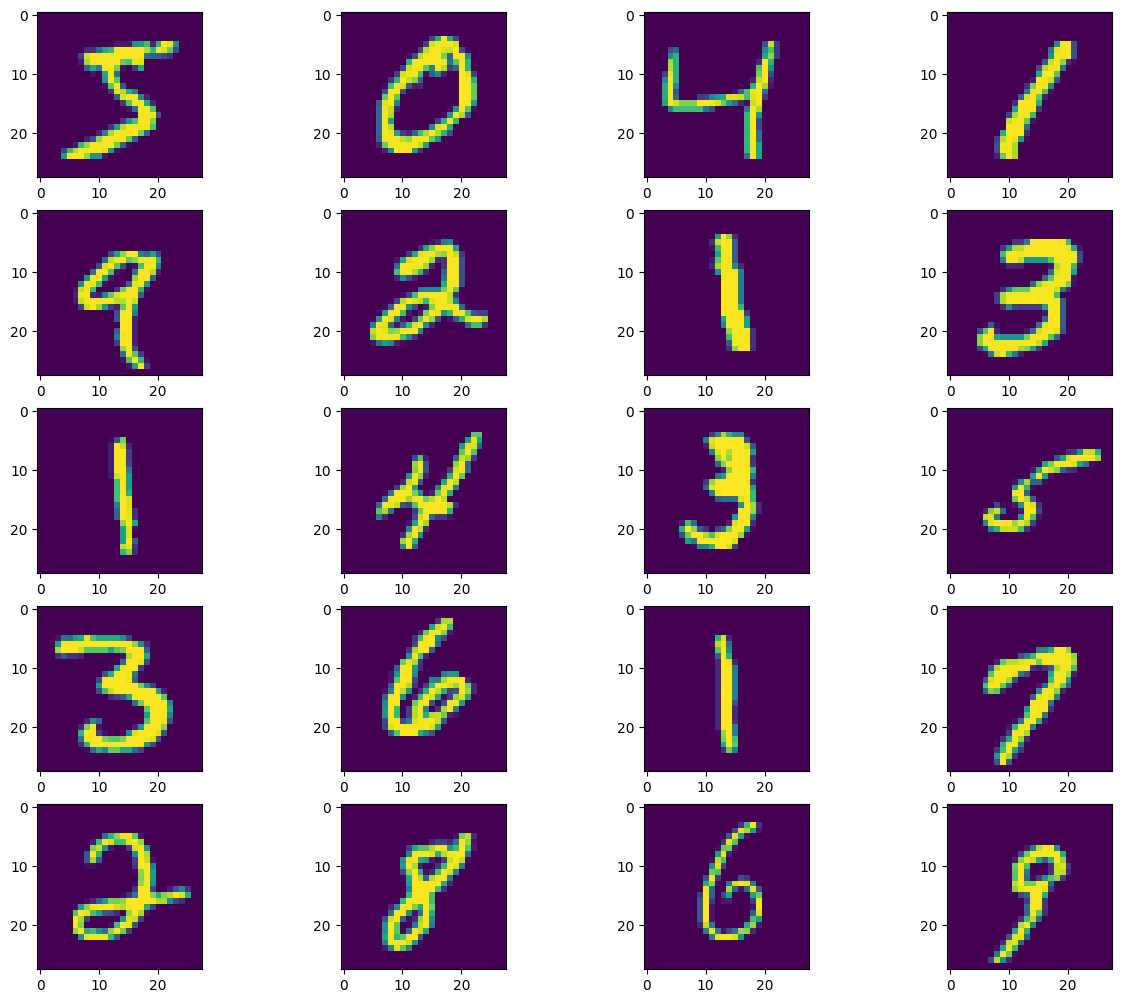

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.MNIST(root=".",train=1,download=True)
show_images(data)

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect.

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [2]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 70
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Let's test it on our dataset ...

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 32
BATCH_SIZE = 512

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.MNIST(root=".", download=True,
                                         transform=data_transform)

    test = torchvision.datasets.MNIST(root=".", download=True,
                                         transform=data_transform, train = 0)
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

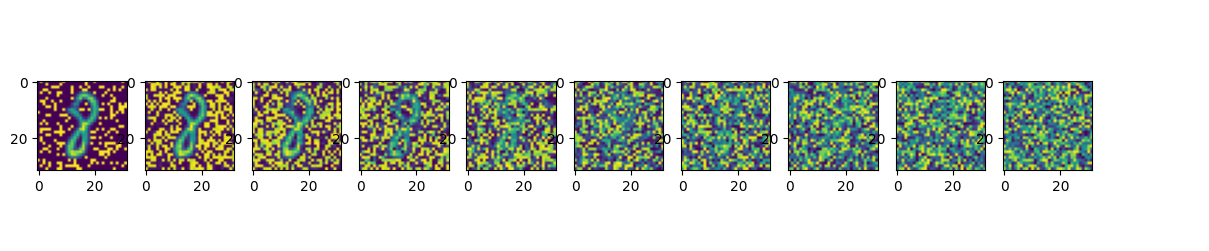

In [4]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,3))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [ ]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256)
        up_channels = (256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.x(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  3691873


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [6]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [12]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,4))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

## Training

In [15]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-2,)
epochs = 20 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if step % 5 == 0 :
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        # sample_plot_image()

/tmp/ipykernel_72670/3315688414.py:4: UserWarning: Using a target size (torch.Size([512, 1, 32, 32])) that is different to the input size (torch.Size([512, 3, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(noise, noise_pred)


Epoch 0 | step 000 Loss: 0.662506103515625 
Epoch 0 | step 005 Loss: 0.8104864954948425 
Epoch 0 | step 010 Loss: 0.8161870241165161 
Epoch 0 | step 015 Loss: 0.8006598949432373 
Epoch 0 | step 020 Loss: 0.7998977899551392 
Epoch 0 | step 025 Loss: 0.7995797991752625 
Epoch 0 | step 030 Loss: 0.7987617254257202 
Epoch 0 | step 035 Loss: 0.7974249124526978 
Epoch 0 | step 040 Loss: 0.7984532713890076 
Epoch 0 | step 045 Loss: 0.7974375486373901 
Epoch 0 | step 050 Loss: 0.798111081123352 
Epoch 0 | step 055 Loss: 0.7981346845626831 
Epoch 0 | step 060 Loss: 0.7979549765586853 
Epoch 0 | step 065 Loss: 0.7969860434532166 
Epoch 0 | step 070 Loss: 0.7969623804092407 
Epoch 0 | step 075 Loss: 0.7988226413726807 
Epoch 0 | step 080 Loss: 0.7980066537857056 
Epoch 0 | step 085 Loss: 0.7981381416320801 
Epoch 0 | step 090 Loss: 0.7978248000144958 
Epoch 0 | step 095 Loss: 0.7974632978439331 


KeyboardInterrupt: 

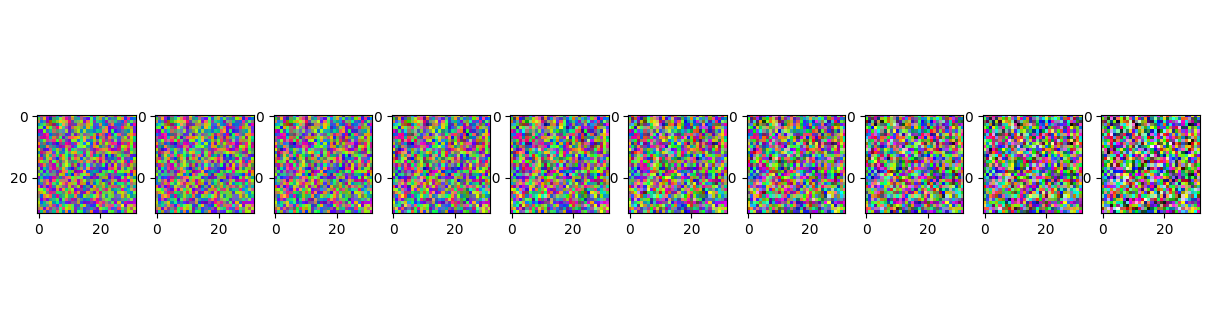

In [13]:

sample_plot_image()